In [ ]:
import json, os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from keras.models import Model
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers import SpatialDropout1D
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input
import tensorflow as tf
from tensorflow.keras import optimizers
from sklearn.utils import class_weight
from keras.layers import Concatenate
#physical_devices = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#INLADEN DATAFRAME NA PREPROCCESING
dataset=pd.DataFrame()
dataset = pd.read_pickle('/content/drive/MyDrive/dataset_prepro.pickle')

In [ ]:
label_list = [ "Electricity",
        "Storm",
        "WaterDamage",
        "Other_DamageType",
        "CracksAndTears",
        "GlassBreakage",
        "Collision",
        "Burglary",
        "Fire_Smoke_Explosion",
        "Theft",
        "Environment_OilFuel",
        "Flooding",]
dataset = dataset[dataset["labels.damage_type"].isin(label_list)]

In [ ]:
n=500
dataset=dataset.set_index(['language', 'mail_content','labels.assignment_type','labels.case_type','labels.sub_case_type','labels.damage_type','attachments_filename'])['attachments_content'].str.split().apply(
               lambda x: pd.Series([' '.join(x[i:i+n]) for i in range(0, len(x), n)])
            ).stack().reset_index().drop('level_7', 1)
dataset.columns = [*dataset.columns[:-1], 'attachments_content']

In [ ]:
y=dataset[['labels.case_type','labels.sub_case_type','labels.damage_type','labels.assignment_type']]
X=dataset.drop(['labels.case_type','labels.sub_case_type','labels.damage_type','labels.assignment_type','language'], axis=1)

In [ ]:
pd.set_option('display.max_colwidth', 100)
X.head()

,mail_content,attachments_filename,attachments_content
0,annexe transmettons document concernant mission confi cadre fense int ts present electronic mes...,MISSION_ASSIGNEMENT,blvd roi ii bic tva rpm entreprise agr nationale belgique pratiquer branches blvd experts sint s...
1,bijlage wij document betrekking opdracht toevertrouwd verdediging onze belangen present electro...,MISSION_ASSIGNEMENT foto 2021-00053-HEFI dd 14.08.2020 Kortrijk schade buurpand - geen ABR -Terr...,nv koning bic btw verzekeringsmaatschappij toegelaten nbb bank codenummer alle beoefenen contact...
2,bijlage wij document betrekking opdracht toevertrouwd verdediging onze belangen present electro...,MISSION_ASSIGNEMENT foto 2021-00053-HEFI dd 14.08.2020 Kortrijk schade buurpand - geen ABR -Terr...,per max uur per per per zuivere onstoffelijke schade per ba stoff schade vermengd per per jaar p...
3,bijlage wij document betrekking opdracht toevertrouwd verdediging onze belangen present electro...,MISSION_ASSIGNEMENT foto 2021-00053-HEFI dd 14.08.2020 Kortrijk schade buurpand - geen ABR -Terr...,wegvallen herziening opzeg dient per aangetekend schrijven gemeld ten laatste maanden geldt bewi...
4,sans mevrouw contacteren verzekeraar bijlage vindt bericht aanleiding waarbij betrokken wij vra...,Polis 1213534_12-29-2020_0240361364 VIVIUM PR C202036457 C36 Inspectie - MS 2021-01-08,historiek num contract ris schade num beschrijving schade datum div polis feel home bijzondere v...


In [ ]:
plt.figure(1 , figsize = (15 , 6))

plt.subplot(1 , 4 , 1)
sns.countplot(x="labels.assignment_type",data=dataset_label_lander)
plt.subplot(1 , 4 , 2)
sns.countplot(x="labels.case_type",data=dataset_label_lander)

plt.figure(2 , figsize = (15 , 6))
plt.subplot(2 , 4 , 1)
sns.countplot(x="labels.sub_case_type",data=dataset_label_lander)
plt.subplot(2 , 4 , 2)
sns.countplot(x="labels.damage_type",data=dataset_label_lander)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state=0)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(8090, 3) (8090, 4)
(2023, 3) (2023, 4)


In [ ]:
#Max number van woorden
MAX_NB_WORDS = 50000
EMBEDDING_DIM = 100

In [ ]:
#mail_content Tokenizer
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(X['mail_content'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X_train_mc = tokenizer.texts_to_sequences(X_train['mail_content'].values)
X_train_mc = pad_sequences(X_train_mc,maxlen=400)
print('Shape of data X_train_mc:', X_train_mc.shape)

X_test_mc = tokenizer.texts_to_sequences(X_test['mail_content'].values)
X_test_mc = pad_sequences(X_test_mc,maxlen=400)
print('Shape of data X_train_mc:', X_test_mc.shape)

Found 561 unique tokens.
Shape of data X_train_mc: (8090, 400)
Shape of data X_train_mc: (2023, 400)


In [ ]:
#attachments_filename Tokenizer
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(X['attachments_filename'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X_train_af = tokenizer.texts_to_sequences(X_train['attachments_filename'].values)
X_train_af = pad_sequences(X_train_af,maxlen=200)
print('Shape of data X_train_af:', X_train_af.shape)

X_test_af = tokenizer.texts_to_sequences(X_test['attachments_filename'].values)
X_test_af = pad_sequences(X_test_af,maxlen=200)
print('Shape of data X_test_af:', X_test_af.shape)

Found 15566 unique tokens.
Shape of data X_train_af: (8090, 200)
Shape of data X_test_af: (2023, 200)


In [ ]:
#attachments_content Tokenizer
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(X['attachments_content'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X_train_ac = tokenizer.texts_to_sequences(X_train['attachments_content'].values)
X_train_ac = pad_sequences(X_train_ac,maxlen=500)
print('Shape of data X_train_ac:', X_train_ac.shape)

X_test_ac = tokenizer.texts_to_sequences(X_test['attachments_content'].values)
X_test_ac = pad_sequences(X_test_ac,maxlen=500)
print('Shape of data X_train_ac:', X_test_ac.shape)

Found 43261 unique tokens.
Shape of data X_train_ac: (8090, 500)
Shape of data X_train_ac: (2023, 500)


In [ ]:
#One-hot multi output
y1_train=pd.DataFrame(columns=pd.get_dummies(y[['labels.assignment_type']]).columns)
y1_test=pd.DataFrame(columns=pd.get_dummies(y[['labels.assignment_type']]).columns)
y2_train=pd.DataFrame(columns=pd.get_dummies(y[['labels.case_type']]).columns)
y2_test=pd.DataFrame(columns=pd.get_dummies(y[['labels.case_type']]).columns)
y3_train=pd.DataFrame(columns=pd.get_dummies(y[['labels.sub_case_type']]).columns)
y3_test=pd.DataFrame(columns=pd.get_dummies(y[['labels.sub_case_type']]).columns)
y4_train=pd.DataFrame(columns=pd.get_dummies(y[['labels.damage_type']]).columns)
y4_test=pd.DataFrame(columns=pd.get_dummies(y[['labels.damage_type']]).columns)

y1_train=y1_train.combine_first(pd.get_dummies(y_train[['labels.assignment_type']])).fillna(0)
print('Shape of label tensor Y1 Train:', y1_train.shape)
y1_test=y1_test.combine_first(pd.get_dummies(y_test[['labels.assignment_type']])).fillna(0)
print('Shape of label tensor Y1 Test:', y1_test.shape)

y2_train=y2_train.combine_first(pd.get_dummies(y_train[['labels.case_type']])).fillna(0)
print('Shape of label tensor Y2 Train:', y2_train.shape)
y2_test=y2_test.combine_first(pd.get_dummies(y_test[['labels.case_type']])).fillna(0)
print('Shape of label tensor Y2 Test:', y2_test.shape)

y3_train=y3_train.combine_first(pd.get_dummies(y_train[['labels.sub_case_type']])).fillna(0)
print('Shape of label tensor Y3 Train:', y3_train.shape)
y3_test=y3_test.combine_first(pd.get_dummies(y_test[['labels.sub_case_type']])).fillna(0)
print('Shape of label tensor Y3 Test:', y3_test.shape)

y4_train=y4_train.combine_first(pd.get_dummies(y_train[['labels.damage_type']])).fillna(0)
print('Shape of label tensor Y4 Train:', y4_train.shape)
y4_test=y4_test.combine_first(pd.get_dummies(y_test[['labels.damage_type']])).fillna(0)
print('Shape of label tensor Y4 Test:', y4_test.shape)

Shape of label tensor Y1 Train: (8090, 2)
Shape of label tensor Y1 Test: (2023, 2)
Shape of label tensor Y2 Train: (8090, 3)
Shape of label tensor Y2 Test: (2023, 3)
Shape of label tensor Y3 Train: (8090, 10)
Shape of label tensor Y3 Test: (2023, 10)
Shape of label tensor Y4 Train: (8090, 12)
Shape of label tensor Y4 Test: (2023, 12)


In [ ]:
# LSTM voor Y1_TRAIN
#adam = tf.keras.optimizers.Adam(lr=0.0001, momentum=0.9, decay=0.01)
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Model checkpoint
checkpoint_filepath = './LSTM_bestmodel.h5'
mc = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath,save_weights_only=True, monitor='val_loss',mode='auto',save_best_only=True)

# Early stopping
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience = 35)

# model
input_mc = Input(shape=(400))
input_af = Input(shape=(200))
input_ac = Input(shape=(500))

model = Sequential()
embeding_mc=Embedding(MAX_NB_WORDS, EMBEDDING_DIM,input_length=X_train_mc.shape[1])(input_mc)
embeding_af=Embedding(MAX_NB_WORDS, EMBEDDING_DIM,input_length=X_train_af.shape[1])(input_af)
embeding_ac=Embedding(MAX_NB_WORDS, EMBEDDING_DIM,input_length=X_train_ac.shape[1])(input_ac)

s_mc=SpatialDropout1D(0.4)(embeding_mc)
o_mc=LSTM(64, dropout=0.4)(s_mc)
s_af=SpatialDropout1D(0.4)(embeding_af)
o_af=LSTM(64, dropout=0.4)(s_af)
s_ac=SpatialDropout1D(0.4)(embeding_ac)
o_ac=LSTM(64, dropout=0.4)(s_ac)
concat_layer = Concatenate()([o_mc, o_af,o_ac])

r=Dense(32, activation='relu')(concat_layer)
lstm1 = Dense(2, activation='softmax')(r)

model = Model(inputs=[input_mc,input_af,input_ac], outputs=[lstm1])
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

history = model.fit([X_train_mc,X_train_af,X_train_ac], y1_train, validation_split=0.2,class_weight=class_weights_assignment, epochs=100,verbose=1,batch_size=64,callbacks=[es])

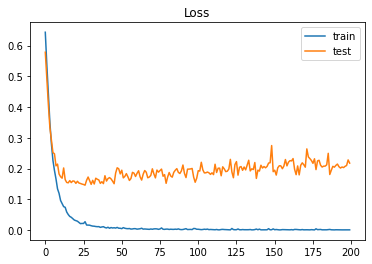

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

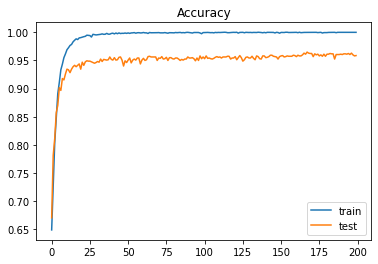

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [ ]:
class_weights_case = dict(zip(np.unique(y2_train), class_weight.compute_class_weight('balanced', np.unique(y2_train), 
                np.ravel(y2_train)))) 

In [ ]:
# LSTM voor Y2_TRAIN
#adam = tf.keras.optimizers.Adam(lr=0.0001, momentum=0.9, decay=0.01)
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Model checkpoint
checkpoint_filepath = './LSTM_bestmodel.h5'
mc = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath,save_weights_only=True, monitor='val_loss',mode='auto',save_best_only=True)

# Early stopping
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience = 35)

# model
input_mc = Input(shape=(400))
input_af = Input(shape=(200))
input_ac = Input(shape=(500))

model = Sequential()
embeding_mc=Embedding(MAX_NB_WORDS, EMBEDDING_DIM,input_length=X_train_mc.shape[1])(input_mc)
embeding_af=Embedding(MAX_NB_WORDS, EMBEDDING_DIM,input_length=X_train_af.shape[1])(input_af)
embeding_ac=Embedding(MAX_NB_WORDS, EMBEDDING_DIM,input_length=X_train_ac.shape[1])(input_ac)

s_mc=SpatialDropout1D(0.4)(embeding_mc)
o_mc=LSTM(64, dropout=0.4)(s_mc)
s_af=SpatialDropout1D(0.4)(embeding_af)
o_af=LSTM(64, dropout=0.4)(s_af)
s_ac=SpatialDropout1D(0.4)(embeding_ac)
o_ac=LSTM(64, dropout=0.4)(s_ac)
concat_layer = Concatenate()([o_mc, o_af,o_ac])
r=Dense(32, activation='relu')(concat_layer)
lstm1 = Dense(3, activation='softmax')(r)

model = Model(inputs=[input_mc,input_af,input_ac], outputs=[lstm1])
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

history = model.fit([X_train_mc,X_train_af,X_train_ac], y2_train, validation_split=0.2, epochs=100,verbose=1,batch_size=64,callbacks=[es])

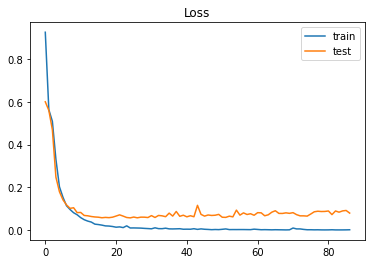

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

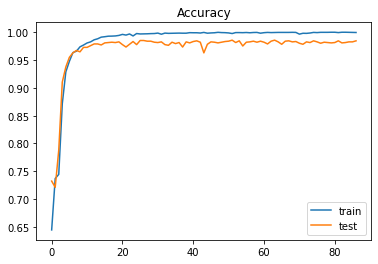

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [ ]:
# LSTM voor Y3_TRAIN
#adam = tf.keras.optimizers.Adam(lr=0.0001, momentum=0.9, decay=0.01)
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Model checkpoint
checkpoint_filepath = './LSTM_bestmodel.h5'
mc = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath,save_weights_only=True, monitor='val_loss',mode='auto',save_best_only=True)

# Early stopping
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience = 35)

# model
input_mc = Input(shape=(400))
input_af = Input(shape=(200))
input_ac = Input(shape=(500))

model = Sequential()
embeding_mc=Embedding(MAX_NB_WORDS, EMBEDDING_DIM,input_length=X_train_mc.shape[1])(input_mc)
embeding_af=Embedding(MAX_NB_WORDS, EMBEDDING_DIM,input_length=X_train_af.shape[1])(input_af)
embeding_ac=Embedding(MAX_NB_WORDS, EMBEDDING_DIM,input_length=X_train_ac.shape[1])(input_ac)

s_mc=SpatialDropout1D(0.4)(embeding_mc)
o_mc=LSTM(16, dropout=0.4)(s_mc)
s_af=SpatialDropout1D(0.4)(embeding_af)
o_af=LSTM(16, dropout=0.4)(s_af)
s_ac=SpatialDropout1D(0.4)(embeding_ac)
o_ac=LSTM(16, dropout=0.4)(s_ac)
concat_layer = Concatenate()([o_mc, o_af,o_ac])
# r=Dense(32, activation='relu')(concat_layer)
lstm1 = Dense(10, activation='softmax')(concat_layer)

model = Model(inputs=[input_mc,input_af,input_ac], outputs=[lstm1])
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

history = model.fit([X_train_mc,X_train_af,X_train_ac], y3_train, validation_split=0.2, epochs=100,verbose=1,batch_size=64,callbacks=[es])

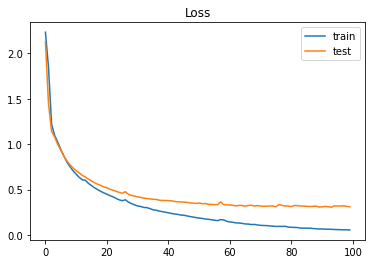

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

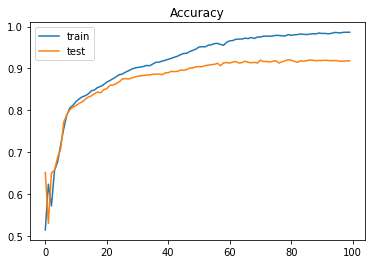

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [ ]:
# LSTM voor Y4_TRAIN
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Model checkpoint
checkpoint_filepath = './LSTM_bestmodel.h5'
mc = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath,save_weights_only=True, monitor='val_loss',mode='auto',save_best_only=True)

# Early stopping
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience = 35)

# model
input_mc = Input(shape=(400))
input_af = Input(shape=(200))
input_ac = Input(shape=(500))

model = Sequential()
embeding_mc=Embedding(MAX_NB_WORDS, EMBEDDING_DIM,input_length=X_train_mc.shape[1])(input_mc)
embeding_af=Embedding(MAX_NB_WORDS, EMBEDDING_DIM,input_length=X_train_af.shape[1])(input_af)
embeding_ac=Embedding(MAX_NB_WORDS, EMBEDDING_DIM,input_length=X_train_ac.shape[1])(input_ac)

s_mc=SpatialDropout1D(0.4)(embeding_mc)
o_mc=LSTM(16, dropout=0.4)(s_mc)
s_af=SpatialDropout1D(0.4)(embeding_af)
o_af=LSTM(16, dropout=0.4)(s_af)
s_ac=SpatialDropout1D(0.4)(embeding_ac)
o_ac=LSTM(16, dropout=0.4)(s_ac)
concat_layer = Concatenate()([o_mc, o_af,o_ac])
# r=Dense(32, activation='relu')(concat_layer)
lstm1 = Dense(12, activation='softmax')(concat_layer)

model = Model(inputs=[input_mc,input_af,input_ac], outputs=[lstm1])
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

history = model.fit([X_train_mc,X_train_af,X_train_ac], y4_train, validation_split=0.2, epochs=100,verbose=1,batch_size=64,callbacks=[es])

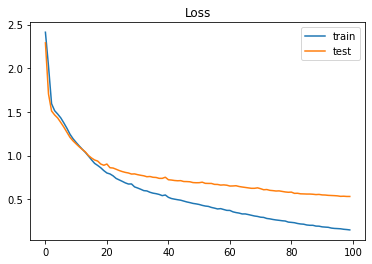

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

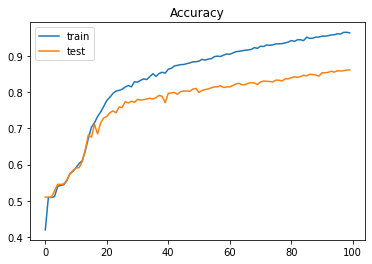

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();